In [1]:
import utils.utils as utils
import os
from egs.visinger2.models import SynthesizerTrn
from text import npu
import IPython.display as ipd
import numpy as np
import torch
from pedalboard import Pedalboard, HighpassFilter, LowpassFilter, Compressor, Reverb, Distortion, Gain
from collections import deque
import time
import soundfile as sf
import matplotlib.pyplot as plt
import shutil
import ipywidgets as widgets
import pyloudnorm as pyln


DEBUG:matplotlib:(private) matplotlib data path: /Users/matthewrice/Developer/VISinger2/env/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /Users/matthewrice/Developer/VISinger2/env/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/matthewrice/.matplotlib
DEBUG:matplotlib:matplotlib version 3.3.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib._abc', 'itertools', 

In [2]:
def parse_label(hps, phos, pitchids, durs, slurs):
    phos = [npu.symbol_converter.ttsing_phone_to_int[pho] for pho in phos]
    pitchs = [npu.symbol_converter.ttsing_opencpop_pitch_to_int[pitchid] for pitchid in pitchids]

    phos = np.asarray(phos, dtype=np.int32)
    pitchs = np.asarray(pitchs, dtype=np.int32)
    durs = np.asarray(durs, dtype=np.float32)
    slurs = np.asarray(slurs, dtype=np.int32)

    phos = torch.LongTensor(phos)
    pitchs = torch.LongTensor(pitchs)
    durs = torch.FloatTensor(durs)
    slurs = torch.LongTensor(slurs)
    return phos, pitchs, durs, slurs


In [3]:
def load_model(model_dir):

    # load config and model
    model_path = utils.latest_checkpoint_path(model_dir)
    config_path = os.path.join(model_dir, "config.json")
    
    hps = utils.get_hparams_from_file(config_path)

    print("Load model from : ", model_path)
    print("config: ", config_path)

    net_g = SynthesizerTrn(hps)
    _ = net_g.eval()
    _ = utils.load_checkpoint(model_path, net_g, None)
    return net_g, hps


In [4]:
def generate_audio(pho, pitchid, dur, slur, model, hps, detune_prob=0):
    with torch.no_grad():
        # data
        pho_lengths = torch.LongTensor([pho.size(0)])
        pho = pho.unsqueeze(0)
        pitchid = pitchid.unsqueeze(0)
        dur = dur.unsqueeze(0)
        slur = slur.unsqueeze(0)

        # infer
        o, _, _ = model.infer(pho, pho_lengths, pitchid, dur, slur, random_detune_prob=detune_prob)
        audio = o[0,0].data.cpu().float().numpy()
        audio = audio * 32768 #hps.data.max_wav_value
        audio = audio.astype(np.int16)
        return audio

In [190]:
def pre_generation_processing(phones, notes, dur, mistakes):
    # Overall Speed
    speed = np.random.normal(1, mistakes / 100)
    for i in range(len(dur)):
        dur[i] = dur[i] * speed
    # Phoneme Speed Change
    phone_speedchange_prob = mistakes / 100
    for i in range(len(dur)):
        if np.random.rand() < phone_speedchange_prob:
            dur[i] = dur[i] * np.random.uniform(0.6, 1.4)
    # Random phoneme replacement
    phone_replace_prob = (mistakes / 100) / 2
    for i in range(len(phones)):
        if phones[i] != "SP" and phones[i] != "AP":
            if np.random.random() < phone_replace_prob:
                phones[i] = np.random.choice(
                    list(npu.symbol_converter.ttsing_phone_to_int.keys())
                )
    return phones, notes, dur

def post_generation_processing(audio, mistakes, confidence, sample_rate):
    # Mistakes-based effects
    normalize = LoudnessNormalize(sample_rate, target_lufs_db=-5)
    board = Pedalboard()
    highpass = HighpassFilter(mistakes * 15) # 0 - 1500
    board.append(highpass)
    lowpass = LowpassFilter(4000 + ((100 - mistakes) * 100)) # 4000 - 14000
    board.append(lowpass)
    apply_distortion = np.random.rand() < (mistakes / 100)

    compressor = Compressor(-mistakes / 10) # 0 - -10, 
    board.append(compressor)
    # Reverb is "good" effect, added with confidence
    dry_wet = (confidence / 100) / 25
    reverb = Reverb(0.7, 0.5, dry_wet, 0.4) 
    board.append(reverb)
    # Gain is "good" effect, changed with confidence
    gain = Gain((confidence / 100) * 20 - 10) # -10 - 10
    board.append(gain)
    if apply_distortion:
        distortion = Distortion(drive_db=np.random.uniform(-40, -60))
        board.append(distortion)

    audio = board(audio.astype(float), sample_rate=sample_rate)
    audio = normalize(audio)

    audio = board(audio.astype(float), sample_rate=sample_rate)    
    return audio


class LoudnessNormalize(torch.nn.Module):
    def __init__(self, sample_rate: float, target_lufs_db: float = -32.0) -> None:
        super().__init__()
        self.meter = pyln.Meter(sample_rate)
        self.target_lufs_db = target_lufs_db

    def forward(self, x: torch.Tensor):
        x_lufs_db = self.meter.integrated_loudness(x.T)
        delta_lufs_db = np.array([self.target_lufs_db - x_lufs_db]).astype(np.float32)
        gain_lin = 10.0 ** (np.clip(delta_lufs_db, -120, 40.0) / 20.0)
        return gain_lin * x


In [128]:
def get_next_song_data():
    phones = ["y","v","l","in","sh","i","l","e","SP","t","ian","k","ong","AP","h","ui","d","e","SP","g","eng","j","iang","j","iu","AP"]
    notes = ["C4", "C4", "D4", "D4", "D4", "D4", "D4", "D4", "rest", "D4", "D4", "A#3/Bb3", "A#3/Bb3", "rest", "A#3/Bb3", "A#3/Bb3", "A#3/Bb3", "A#3/Bb3", "rest", "A#3/Bb3", "A#3/Bb3", "A#3/Bb3", "A#3/Bb3", "D#4/Eb4", "D#4/Eb4", "rest"]
    note_dur = [0.232140, 0.232140, 0.160180, 0.160180, 0.363150, 0.363150, 0.161340, 0.161340, 0.074290, 0.280500, 0.280500, 0.502820, 0.502820, 0.211830, 0.301390, 0.301390, 0.116070, 0.116070, 0.122460, 0.252690, 0.252690, 0.502010, 0.502010, 0.475340, 0.475340, 0.335450]
    slurs = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    return phones, notes, note_dur, slurs

In [129]:
model_dir = "/Users/matthewrice/Developer/VISinger2/ckpt"
model, hps = load_model(model_dir)

/Users/matthewrice/Developer/VISinger2/ckpt/G_200000.pth
Load model from :  /Users/matthewrice/Developer/VISinger2/ckpt/G_200000.pth
config:  /Users/matthewrice/Developer/VISinger2/ckpt/config.json
load 
INFO:root:Loaded checkpoint '/Users/matthewrice/Developer/VISinger2/ckpt/G_200000.pth' (iteration 905)


In [131]:
class LearnerStateModel():
    def __init__(self, init_motivation, init_artistry):
        self.motivation = init_motivation
        self.artistry = init_artistry
        self.std = 5
        self.max_mistake_memory = 10
        self.motivation_factor = 0.01
        self.mistakes_history_factor = 0.001
        self.mistakes_deque = deque(maxlen=self.max_mistake_memory)
        self.mistake_factor = self.motivation * self.motivation_factor
        self.mistake_memory = self.max_mistake_memory
        self.time_step = 0
        # Initial confidence is close to artistry
        self.confidence = np.clip(self.artistry - 10, 0, 100)
        # Initial mistakes is close to artistry
        self.mistakes_mean = np.clip(100 - self.artistry * 0.55 - self.motivation * 0.45, 0, 100)
        self.mistakes = int(np.clip(np.random.normal(self.mistakes_mean, self.std), 0, 100)) 

    
    def get_confidence(self):
        return self.confidence
    
    def get_mistakes(self):
        return self.mistakes
    
    def get_motivation(self):
        return self.motivation
    
    def get_artistry(self):
        return self.artistry

    def step(self):
        # State Machine
        # Number of new mistakes = number of new mistakes + artistry + motivation * motivation factor + total_mistakes
        self.mistakes_mean = np.clip(100 - self.artistry * 0.55 - self.motivation * 0.45, 0, 100)
        self.mistakes = int(np.clip(np.random.normal(self.mistakes_mean, self.std), 0, 100))
        self.mistakes_deque.appendleft(self.mistakes)
        # Confidence = number of new mistakes * mistake factor + artistry
        self.confidence_mean = self.artistry - self.mistakes * self.mistake_factor
        self.confidence = int(np.clip(np.random.normal(self.confidence_mean, self.std), 0, 100))
        # Artistry = number of new mistakes
        self.artistry_mean = 100 - self.mistakes + self.time_step * self.motivation 
        self.artistry = (self.artistry + int(np.clip(np.random.normal(self.artistry_mean, self.std), 0, 100))) / 2
        # Motivation = artistry + total mistakes
        self.motivation_mean = self.artistry - sum(list(self.mistakes_deque)[:self.mistake_memory]) * self.mistakes_history_factor
        self.motivation = (self.motivation + int(np.clip(np.random.normal(self.motivation_mean, self.std), 0, 100))) / 2
        # Mistake factor = motivation * motivation factor
        self.mistake_factor = self.motivation * self.motivation_factor
        # Mistake memory = confidence 
        self.mistake_memory = int(self.max_mistake_memory - self.confidence / self.max_mistake_memory)
        self.mistakes_history_factor = (100 - self.motivation / 100) * 0.01
        self.time_step += 1
        



In [5]:
lm = LearnerStateModel(init_motivation=78, init_artistry=26)
mistakes = [0]
confidence = [lm.get_confidence()]
artistry = [lm.get_artistry()]
motivation = [lm.get_motivation()]
mistake_memory = [lm.max_mistake_memory]


for i in range(50):
    lm.step()
    mistakes.append(lm.get_mistakes())
    confidence.append(lm.get_confidence())
    artistry.append(lm.artistry)
    motivation.append(lm.motivation)
    mistake_memory.append(lm.mistake_memory)

for i, (x, y) in enumerate(zip(motivation, motivation[1:])):
    if x < 1 and y < 1:
        print("Motivation is stuck at 0")
        print(f"Give up at time step {i}")

# Separate plots
plt.subplots(3, 2, figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(mistakes)
plt.title("Mistakes")
plt.subplot(3, 2, 2)
plt.plot(confidence)
plt.title("Confidence")
plt.subplot(3, 2, 3)
plt.plot(artistry)
plt.title("Artistry")
plt.subplot(3, 2, 4)
plt.plot(motivation)
plt.title("Motivation")
plt.subplot(3, 2, 5)
plt.plot(mistake_memory)
plt.title("Mistake Memory")
plt.show()


NameError: name 'LearnerStateModel' is not defined

In [170]:
def learn_to_sing(singer_model, learner_model):
    output_dir = "learner_outputs"
    shutil.rmtree(output_dir, ignore_errors=True)
    os.mkdir(output_dir)

    time_step = 0
    prev_motivation = 1
    prev_confidence = 1
    outputs = []
    total_mistakes = []
    confidences = []
    artistries = []
    motivations = []
    mistake_memories = []

    while True:
        mistakes = learner_model.get_mistakes()
        confidence = learner_model.get_confidence()
        motivation = learner_model.get_motivation()
        artistry = learner_model.get_artistry()
        if time_step == 50 or (motivation < 1 and prev_motivation < 1) or (confidence > 99 and prev_confidence > 99):
            print("--------- FINISHED ---------")
            print(f"Motivation: {motivation}")
            print(f"Confidence: {confidence}")
            print(f"Artistry: {artistry}")
            print(f"Mistakes: {mistakes}")
            break

        # Get next song data
        phones, notes, dur, slurs = get_next_song_data()
        # pre: mistakes from overall speed, phoneme speed change, random phoneme replacement 
        phones, notes, dur = pre_generation_processing(phones, notes, dur, mistakes)
        phones, notes, dur, slurs = parse_label(hps, phones, notes, dur, slurs)
        # During: Detune mistakes
        audio = generate_audio(phones, notes, dur, slurs, detune_prob = mistakes / 100)
        # Post: mistakes from filtering, distortion, compression. Confidence-controlled Reverb, Gain
        audio = post_generation_processing(audio, mistakes, confidence, hps.data.sample_rate)
        sf.write(f"learner_outputs/{time_step}_output.wav", audio, hps.data.sample_rate)
        outputs.append(audio)

        print(f"--------- Time step: {time_step} ---------")
        print("Confidence", confidence)
        print("Motivation", motivation)
        print("Artistry", artistry)
        print("Mistakes", mistakes)
        learner_model.step()
        total_mistakes.append(mistakes)
        confidences.append(confidence)
        artistries.append(artistry)
        motivations.append(motivation)
        mistake_memories.append(learner_model.mistake_memory)
        time_step += 1
        prev_motivation = motivation
        prev_confidence = confidence
    print("Total time steps", time_step)
    return outputs, total_mistakes, confidences, artistries, motivations, mistake_memories
        

--------- Time step: 0 ---------
Confidence 40
Motivation 46
Artistry 50
Mistakes 49
--------- Time step: 1 ---------
Confidence 30
Motivation 48.0
Artistry 53.5
Mistakes 49
--------- Time step: 2 ---------
Confidence 40
Motivation 24.0
Artistry 76.75
Mistakes 46
--------- Time step: 3 ---------
Confidence 67
Motivation 12.0
Artistry 88.375
Mistakes 34
--------- Time step: 4 ---------
Confidence 82
Motivation 6.0
Artistry 84.6875
Mistakes 46
--------- Time step: 5 ---------
Confidence 93
Motivation 12.0
Artistry 78.84375
Mistakes 56
--------- Time step: 6 ---------
Confidence 59
Motivation 50.0
Artistry 89.421875
Mistakes 55
--------- Time step: 7 ---------
Confidence 85
Motivation 25.0
Artistry 94.7109375
Mistakes 27
--------- Time step: 8 ---------
Confidence 81
Motivation 46.5
Artistry 97.35546875
Mistakes 36
--------- Time step: 9 ---------
Confidence 81
Motivation 51.75
Artistry 98.677734375
Mistakes 38
--------- Time step: 10 ---------
Confidence 74
Motivation 63.875
Artistry 99.

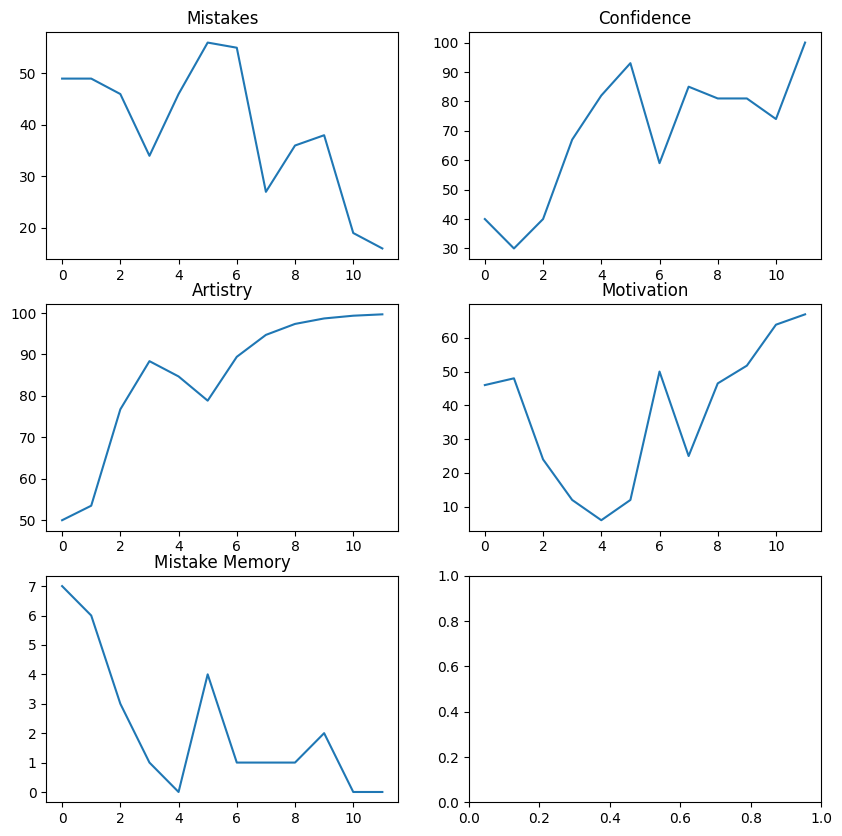

In [196]:

lm = LearnerStateModel(init_motivation=46, init_artistry=50)
outputs, total_mistakes, confidences, artistries, motivations, mistake_memories = learn_to_sing(model, lm)
plt.subplots(3, 2, figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(total_mistakes)
plt.title("Mistakes")
plt.subplot(3, 2, 2)
plt.plot(confidences)
plt.title("Confidence")
plt.subplot(3, 2, 3)
plt.plot(artistries)
plt.title("Artistry")
plt.subplot(3, 2, 4)
plt.plot(motivations)
plt.title("Motivation")
plt.subplot(3, 2, 5)
plt.plot(mistake_memories)
plt.title("Mistake Memory")
plt.show()


In [194]:
for i, output in enumerate(outputs):
    ipd.display(widgets.Label(f"Step {i}"), ipd.Audio(output, rate=hps.data.sample_rate))

Label(value='Step 0')

Label(value='Step 1')

Label(value='Step 2')

Label(value='Step 3')

Label(value='Step 4')

Label(value='Step 5')

Label(value='Step 6')

Label(value='Step 7')